# Demonstration of Text Normalization using Memory Augmented Neural Networks
---

This notebook and the accompanying paper [Text Normalization using Memory Augmented Neural Networks](https://arxiv.org/?) demonstrates an accuracy of 99.5% on the Text Normalization Challenge by Richard Sproat and Navdeep Jaitly. The approach used here has secured the 6th position in the [Kaggle Russian Text Normalization Challenge](https://www.kaggle.com/c/text-normalization-challenge-russian-language) by Google's Text Normalization Research Group.

# Table of Contents
---
1. [Import Dependencies](#import)
2. [Global Config](#config)
3. [Load Dataset](#load)
4. [XGBoost Classification](#xgb)
5. [Encode Data](#encode)
6. [DNC Normalization](#dnc)
7. [Data Postprocessing](#post)
8. [Results Analysis](#result)
9. [Conclusion](#conclusion)

___

## 1. Import Dependencies
<a id="import"></a>

### Import Libraries

In [1]:
import os
import gc
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score

import xgboost as xgb
import tensorflow as tf

%matplotlib inline

/home/aman/anaconda3/envs/deep-tf/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%load_ext autoreload
%autoreload 2

### Import Utilities

In [3]:
sys.path.append("../src")

from utils import Encoder
from utils import Normalized2String
from XGBclassify import XGB
import DNCnormalize

**System Information**

In [4]:
%load_ext watermark
%watermark -v -n -m -p numpy,pandas,matplotlib,seaborn,sklearn,xgboost,tensorflow

Fri Dec 29 2017 

CPython 3.6.3
IPython 6.2.1

numpy 1.13.3
pandas 0.21.0
matplotlib 2.1.0
seaborn 0.8.1
sklearn 0.19.1
xgboost 0.6
tensorflow 1.3.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.4.0-77-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


## 2. Global Config
<a id="config"></a>


**Language : English or Russian?**

In [5]:
lang = 'english'
# lang = 'russian'

In [6]:
if lang == 'english':
    # input data
    data_directory = '../data/english/'
    data = data_directory+'output-00099-of-00100_processed.csv'
    vocab = data_directory+'en_vocab.data'
    vocab_size = 120
    # interim data
    encoded_file = data_directory+'en_encoded.npy'
    encoded_len_file = data_directory+'en_encoded_len.npy'
    normalized_file = data_directory+'en_normalized.npy'
    # model
    model_directory = '../models/english/'
    xgb_path = model_directory+'en-xgb[0.5]'
    dnc_name = 'translate.ckpt'
    end_token = 0
    # kaggle test data
    kg_data = data_directory+'en_test.csv'
    # ground truth labels
    truth = data_directory+'en_solution.csv'
    # results
    result_dir = '../results/english/'
    result_csv = 'normalized.csv'

elif lang == 'russian':
    # input data
    data_directory = '../data/russian/'
    data = data_directory+'output-00099-of-00100_processed.csv'
    vocab = data_directory+'ru_vocab.data'
    vocab_size = 180
    # interim data
    encoded_file = data_directory+'ru_encoded.npy'
    encoded_len_file = data_directory+'ru_encoded_len.npy'
    normalized_file = data_directory+'ru_normalized.npy'
    # model
    model_directory = '../models/russian/'
    xgb_path = model_directory+'ru-xgb[1.0]'
    dnc_name = 'final_model.ckpt'
    end_token = -1
    # kaggle test data
    kg_data = data_directory+'ru_test.csv'
    # ground truth labels
    truth = data_directory+'ru_solution.csv'
    # results
    result_dir = '../results/russian/'
    result_csv = 'normalized.csv'

## 3. Load Dataset
<a id="load"></a>

**Dataset by Sproat and Jaitly (2016) - An RNN Model of Text Normalization**  
- English Source: [https://storage.googleapis.com/text-normalization/en_with_types.tgz]  
- Russian Source: [https://storage.googleapis.com/text-normalization/ru_with_types.tgz]  
*The data is preprocessed for achieving results comparable to the ones presented in the above mentioned paper.*

**Read CSV as DataFrame**

In [7]:
raw_data = pd.read_csv(data)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93196 entries, 0 to 93195
Data columns (total 5 columns):
sentence_id    93196 non-null int64
token_id       93196 non-null int64
semiotic       93196 non-null object
before         93196 non-null object
after          93196 non-null object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


In [8]:
raw_data.head()

,sentence_id,token_id,semiotic,before,after
0,0,0,PLAIN,Сбор,Сбор
1,0,1,PUNCT,),)
2,0,2,PUNCT,—,—
3,0,3,PLAIN,село,село
4,0,4,PLAIN,в,в


**Dropping the ground truth labels**

In [9]:
raw_data.drop(columns=['after'], inplace=True)

## 4. XGBoost Classification  
<a id="xgb"></a>
**ToBeNormalized or RemainSame**

In [10]:
# instantiate and load trained
# XGBoost Model for classification
xgb = XGB(xgb_path)

In [11]:
# Class of tokens in the data
raw_data['class'] = xgb.predict(data=raw_data)
# Raw to Classified Data
classified_data = raw_data.copy(deep=False)

In [12]:
classified_data.sample(n=10)

,sentence_id,token_id,semiotic,before,class
11720,869,13,PUNCT,",",RemainSelf
80263,5871,8,PLAIN,подчиненный,RemainSelf
64576,4703,8,PLAIN,квадратный,RemainSelf
68758,5009,10,PLAIN,Занимает,RemainSelf
62419,4553,5,PLAIN,необходимы,RemainSelf
84017,6142,7,PUNCT,",",RemainSelf
51132,3725,5,PLAIN,проживает,RemainSelf
28983,2103,19,PLAIN,Игорем,RemainSelf
83071,6074,5,PUNCT,",",RemainSelf
46831,3406,16,PUNCT,.,RemainSelf


In [13]:
id_tobenormalized = classified_data.index[classified_data['class']=='ToBeNormalized'].tolist()
id_remainself = classified_data.index[classified_data['class']=='RemainSelf'].tolist()

Sanity Check...

In [14]:
print('Tokens to be normalized : {}'.format(len(id_tobenormalized)))
print('Tokens to remain self : {}'.format(len(id_remainself)))

Tokens to be normalized : 11213
Tokens to remain self : 81983


## 5. Encode Data
<a id="encode"></a>

In [15]:
# Instatiate encoder with the vocabulary
encoder = Encoder(vocab_file=vocab)

In [16]:
# use existing Encoder Decoder parameters
# to perform the decoding of the test data
enc_data, enc_len = encoder.encode(classified_data)

In [17]:
# encode 'tobenormalized' tokens only
tobenormalized_enc_data = enc_data[id_tobenormalized]
tobenormalized_enc_len = enc_len[id_tobenormalized]

Sanity check...

In [18]:
print('Tokens to be normalized : {}'.format(len(tobenormalized_enc_data)))

Tokens to be normalized : 11213


Saving encoded data

In [19]:
np.save(encoded_file, tobenormalized_enc_data)
np.save(encoded_len_file, tobenormalized_enc_len)

## 6. DNC Normalization
<a id="dnc"></a>
**Generate Normalized Form**

In [20]:
tobenormalized_enc_data = np.load(encoded_file)
tobenormalized_enc_len = np.load(encoded_len_file)

In [21]:
# DNC tensorflow flag parameters
tf.flags.DEFINE_string('model_dir', model_directory, 'Path to save model checkpoints')
tf.flags.DEFINE_string('model_name', dnc_name, 'File name used for model checkpoints')
tf.flags.DEFINE_integer('num_encoder_symbols', vocab_size, 'Source vocabulary size')
tf.flags.DEFINE_integer('end_token', end_token, 'Start Token')

In [22]:
normalized_data = DNCnormalize.normalize(tobenormalized_enc_data, tobenormalized_enc_len)

Using DNC model at ../models/russian/
building model..
building encoder..
building decoder and attention..
building greedy decoder..
Reloading model parameters...
INFO:tensorflow:Restoring parameters from ../models/russian/final_model.cpkt
model restored from ../models/russian/final_model.cpkt
Number of batches: 56
Normalized 200 out of 11200
Normalized 600 out of 11200
Normalized 1000 out of 11200
Normalized 1400 out of 11200
Normalized 1800 out of 11200
Normalized 2200 out of 11200
Normalized 2600 out of 11200
Normalized 3000 out of 11200
Normalized 3400 out of 11200
Normalized 3800 out of 11200
Normalized 4200 out of 11200
Normalized 4600 out of 11200
Normalized 5000 out of 11200
Normalized 5400 out of 11200
Normalized 5800 out of 11200
Normalized 6200 out of 11200
Normalized 6600 out of 11200
Normalized 7000 out of 11200
Normalized 7400 out of 11200
Normalized 7800 out of 11200
Normalized 8200 out of 11200
Normalized 8600 out of 11200
Normalized 9000 out of 11200
Normalized 9400 ou

Sanity Check...

In [23]:
len(tobenormalized_enc_data)

11213

In [24]:
len(normalized_data)

11400

**Saving the normalized form**

In [25]:
np.save(normalized_file, normalized_data)

## 7. Data Postprocessing
<a id="post"></a>

**Load Normalized Data**

In [26]:
normalized_data = np.load(normalized_file)

**Encoded from to String form**

In [27]:
# Converting the numpy array to a list form
normalized_data = normalized_data[0:tobenormalized_enc_len.shape[0]]
normalized_data = np.split(normalized_data, normalized_data.shape[0])

Sanity check

In [28]:
print('Total instances : {}'.format(len(normalized_data)))
print('Shape of each instance : {}'.format(normalized_data[0].shape))

Total instances : 11213
Shape of each instance : (1, 1, 50, 1)


In [29]:
# Reshaping the nested numpy arrays
for i in range(len(normalized_data)):
    normalized_data[i] = np.reshape(normalized_data[i],
                                    normalized_data[i].shape[2])

In [30]:
# Converting encoded to string format
str_converter = Normalized2String(vocab)
for i in range(len(normalized_data)):
    normalized_data[i]=str_converter.to_str(normalized_data[i])

A sneak peek...

In [31]:
normalized_data[10]

'х_trans о_trans л_trans т_trans'

**Merging Normalized with Remain Self**

In [32]:
classified_data['after'] = ''

Normalized

In [33]:
classified_data.loc[id_tobenormalized, 'after'] = normalized_data


RemainSelf

In [34]:
classified_data.loc[id_remainself, 'after'] = classified_data.loc[id_remainself, 'before'] 

A sneak peek into the final results...

In [35]:
classified_data.sample(10)

,sentence_id,token_id,semiotic,before,class,after
1924,143,1,PLAIN,клинские,RemainSelf,клинские
10195,758,3,PLAIN,рискнуть,RemainSelf,рискнуть
20262,1473,8,PUNCT,.,RemainSelf,.
13018,965,8,PLAIN,водного,RemainSelf,водного
11986,887,16,CARDINAL,350500,ToBeNormalized,трехсот пятидесяти тысяч пятисот
80871,5913,4,PLAIN,понять,RemainSelf,понять
57639,4197,12,PLAIN,солдат,RemainSelf,солдат
91708,6703,4,PUNCT,(,RemainSelf,(
76077,5558,13,PUNCT,.,RemainSelf,.
19627,1425,3,VERBATIM,і,RemainSelf,і


Store the results

In [36]:
classified_data.to_csv(result_dir+result_csv, index=False)

## 8. Results Analysis
<a id="result"></a>

In [7]:
results = pd.read_csv(result_dir+result_csv)
truth = pd.read_csv(data)

**Overall Accuracy**

In [8]:
score = accuracy_score(truth['after'].tolist(),
                       results['after'].tolist())

In [9]:
print('Accuracy on {} language is {:.5f}'.format(lang, score))

Accuracy on english language is 0.99533


**Semiotic class-wise accuracy**

In [10]:
results_group = results.groupby('semiotic')
truth_group = truth.groupby('semiotic')

In [11]:
class_accuracy = pd.DataFrame(columns=['semiotic-class', 'accuracy', 'count', 'correct'])
row = {'semiotic-class': 'ALL',
       'accuracy': score,
       'count': results.shape[0],
       'correct': score*results.shape[0]}
class_accuracy = class_accuracy.append(row, ignore_index=True)

for results_items, truth_items in zip(results_group, truth_group):
    semiotic_class = results_items[0]
    results_items = results_items[1]
    truth_items = truth_items[1]
    score = accuracy_score(truth_items['after'].tolist(),
                          results_items['after'].tolist())
    row = {'semiotic-class': semiotic_class,
           'accuracy': score,
           'count': results_items.shape[0],
           'correct': score*results_items.shape[0]}
    class_accuracy = class_accuracy.append(row, ignore_index=True)
class_accuracy['correct'] = class_accuracy['correct'].astype(int)

In [12]:
class_accuracy

,semiotic-class,accuracy,count,correct
0,ALL,0.995327,92451,92019
1,ADDRESS,1.000000,4,4
2,CARDINAL,0.991321,1037,1028
3,DATE,0.997528,2832,2825
4,DECIMAL,1.000000,92,92
5,DIGIT,0.863636,44,38
6,ELECTRONIC,0.000000,49,0
7,FRACTION,0.625000,16,10
8,LETTERS,0.931867,1409,1313
9,MEASURE,0.971831,142,138


/home/aman/anaconda3/envs/deep-tf/lib/python3.6/site-packages/pandas/plotting/_core.py:1714: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


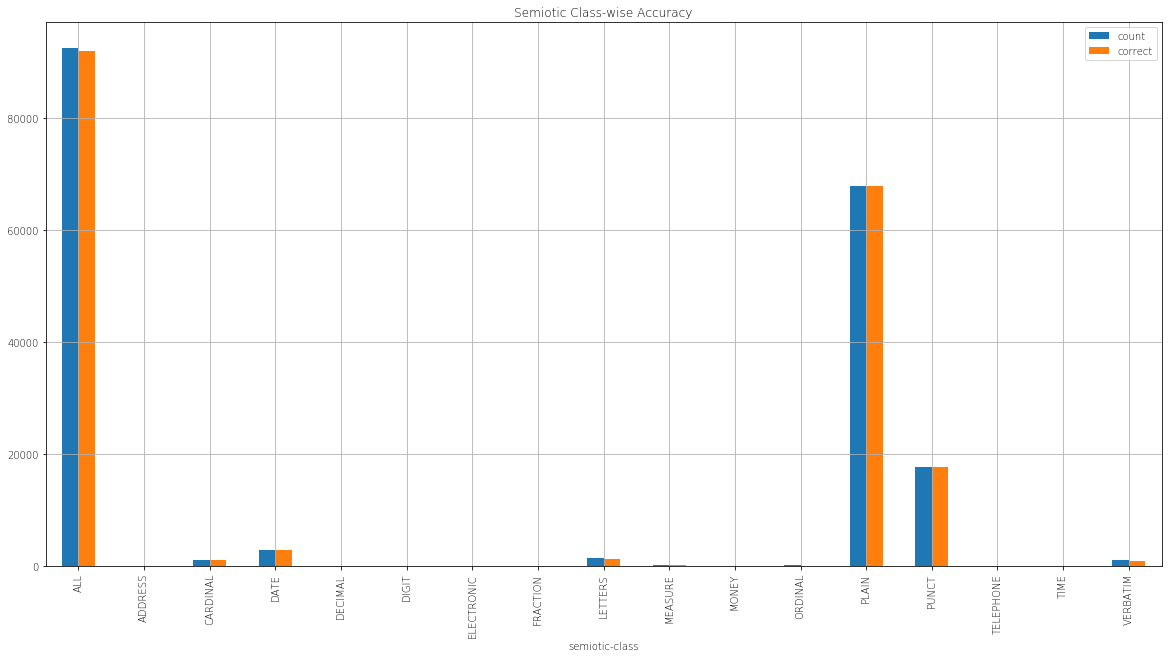

In [13]:
class_accuracy.plot(title='Semiotic Class-wise Accuracy',
                    y=['count', 'correct'], x='semiotic-class',
                    kind='bar', figsize=(20,10), grid=True)
plt.savefig(result_dir+'Semiotic_Class-wise_Accuracy.png')

In [14]:
class_accuracy.to_csv(result_dir+'classwise_accuracy.csv')

**Normalization Mistakes**

In [15]:
mistake_mask = (results['after'] != truth['after'])
mistakes = results[mistake_mask]
mistakes = mistakes.assign(truth = truth.loc[mistake_mask, 'after'])

In [16]:
mistakes.sample(10)

,sentence_id,token_id,semiotic,before,class,after,truth
17043,1369,0,PLAIN,CY,ToBeNormalized,c y,CY
49698,4085,16,VERBATIM,Α,ToBeNormalized,<UNK>,alpha
65343,5371,3,PLAIN,odour,RemainSelf,odour,odor
73186,6009,8,PLAIN,PAC,ToBeNormalized,p a c,PAC
90483,7385,1,LETTERS,Suat,RemainSelf,Suat,s u a t
35568,2925,4,VERBATIM,ggFTW,RemainSelf,ggFTW,g g f t w
78309,6410,19,PLAIN,DID,ToBeNormalized,d i d,DID
49714,4085,32,VERBATIM,Η,ToBeNormalized,<UNK>,eta
38743,3162,1,ELECTRONIC,informationhttp://dynamic.stlouis-mo.gov/censu...,ToBeNormalized,i n f o r m a t i o n h t t p c o l o n s l a ...,i_letter _letter n_letter _letter f_letter ...
49746,4085,64,VERBATIM,Β,ToBeNormalized,<UNK>,beta


**Class-wise mistakes**

In [18]:
mistakes_grouped = mistakes.groupby('semiotic')

In [19]:
mistakes_grouped.apply(lambda x: x.sample(n=3, replace=True))

sentence_id  token_id    semiotic             before  \
semiotic                                                                 
CARDINAL   13202         1060         2    CARDINAL                 21   
           40541         3311         8    CARDINAL                  X   
           13202         1060         2    CARDINAL                 21   
DATE       49265         4049         1        DATE               2011   
           69318         5699         5        DATE         the 15 May   
           48286         3967        11        DATE         14-04-2014   
DIGIT      17657         1414         2       DIGIT                450   
           36933         3024        13       DIGIT                 11   
           77390         6339         2       DIGIT               2013   
ELECTRONIC 24389         1969         0  ELECTRONIC          BioLib.cz   
           68600         5644         9  ELECTRONIC        Gizmodo.com   
           66566         5479         2  ELECTRONIC     bumpworthy.com   
FRACTION   3887           309         0    FRACTION                1/0   
           5633           455         3    FRACTION         10/618,543   
           3887           309         0    FRACTION                1/0   
LETTERS    10413          830         9     LETTERS              GEOPE   
           83179         6800        15     LETTERS          DIMETHYL-   
           31863         2622         8     LETTERS                 AT   
MEASURE    2023           156         3     MEASURE     0.001251 g/cm3   
           51723         4244        12     MEASURE               2 mA   
           81418         6654        20     MEASURE              1220m   
MONEY      70524         5793         4       MONEY              Rs.10   
           21543         1726        11       MONEY   88.5 million HRK   
           21543         1726        11       MONEY   88.5 million HRK   
ORDINAL    87089         7120        15     ORDINAL               XIII   
           81338         6650         8     ORDINAL                  I   
           50278         4128         3     ORDINAL                  V   
PLAIN      48087         3952         6       PLAIN               Xtra   
           60414         4960         1       PLAIN     secularisation   
           91255         7440         5       PLAIN                 GO   
PUNCT      27858         2275         1       PUNCT                  -   
           55676         4572         1       PUNCT                  -   
           55676         4572         1       PUNCT                  -   
TELEPHONE  51054         4189         6   TELEPHONE      1999-2000 BCA   
           80858         6612         8   TELEPHONE  978-94-007-3962-8   
           51054         4189         6   TELEPHONE      1999-2000 BCA   
TIME       88776         7250         3        TIME            0:02:01   
           88069         7196        10        TIME          18:00:00Z   
           88776         7250         3        TIME            0:02:01   
VERBATIM   49737         4085        55    VERBATIM                  Ο   
           86696         7086         4    VERBATIM                Ngn   
           49744         4085        62    VERBATIM                  Θ   

                           class  \
semiotic                           
CARDINAL   13202  ToBeNormalized   
           40541      RemainSelf   
           13202  ToBeNormalized   
DATE       49265  ToBeNormalized   
           69318      RemainSelf   
           48286  ToBeNormalized   
DIGIT      17657  ToBeNormalized   
           36933  ToBeNormalized   
           77390  ToBeNormalized   
ELECTRONIC 24389  ToBeNormalized   
           68600  ToBeNormalized   
           66566  ToBeNormalized   
FRACTION   3887   ToBeNormalized   
           5633   ToBeNormalized   
           3887   ToBeNormalized   
LETTERS    10413      RemainSelf   
           83179      RemainSelf   
           31863      RemainSelf   
MEASURE    2023   ToBeNormalized   
     

In [20]:
mistakes.to_csv(result_dir+'mistakes.csv')

## 9. Conclusion
<a id="conclusion"></a>

**English Normalization Accuracy: 0.99533 **

**Russian Normalization Accuracy: 0.99222**

**For the Test dataset downloaded from Kaggle**  
- English Accuracy : **0.99463**  
Data Source : [https://www.kaggle.com/c/text-normalization-challenge-english-language/download/en_test.csv.zip]  
Ground Truth : [https://kaggle2.blob.core.windows.net/forum-message-attachments/243663/7914/en_solution.csv.zip]  

  
  
- Russian  
Data Source : [https://www.kaggle.com/c/text-normalization-challenge-russian-language/download/ru_test.csv.zip]  
Ground Truth : [https://kaggle2.blob.core.windows.net/forum-message-attachments/243682/7915/ru_solution.csv.zip]  


___